In [1]:
import sys
import os
import numpy as np
import pandas as pd
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('"Top 10 Funds by AUM Positioning - Data Gen.ipynb"')))))
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('"Top 10 Funds by AUM Positioning - Data Gen.ipynb"')))))
import apis.qe.myqengine as qe

Python-dotenv could not parse statement starting at line 5


In [2]:
time_series = qe.TimeSeries(start_date = '-23M',end_date = '0M', frequency='M',calendar='NAY')

univ = qe.IdUniverse(ids = ['AAPL-US','META-US','AMZN-US','NVDA-US','GOOGL-US','MSFT-US','TSLA-US'],universe_type='Equity')
req = qe.calculate(universe = univ, dates = time_series,formulas = ["FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,ANN_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                                            "FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')",
                                           "FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')",
                                           "FE_BROKER_ESTIMATE(SNAP,EPS,PREV_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')",
                                        "FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,ANN,+1,'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')",
                                        "FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,ANN,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                                        "P_PRICE_RETURNS(1,20220831,#DATE,RANGE,USD)"],
                                        source = 'FqlExpression',
                                        is_array_return_type=True)


In [3]:

df = req.data.rename(columns={'UNIVERSE':"Ticker"}).set_index("Ticker")
df.head()

,DATE,"FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,ANN_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')","FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')","FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')","FE_BROKER_ESTIMATE(SNAP,EPS,PREV_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')","FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,ANN,+1,'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')","FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,ANN,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')","P_PRICE_RETURNS(1,20220831,#DATE,RANGE,USD)"
Ticker,,,,,,,,
AAPL-US,20210930,"[Evercore ISI, KGI Securities, Cross Research,...","[Christine Wang, Matthew Cabral, Krish Sankar,...","[5.54, 5.55, 6.2, 5.9, 5.31, 6.19, 6.36, 5.765...","[5.54, 5.55, 6.2, 5.9, 5.31, 6.19, 6.36, 5.765...","[20210915, 20210924, 20210913, 20210915, 20210...","[06GXLQ-E, 09L3VL-E, 06G8B9-E, 06TFSB-E, 079CV...",[11.7455845]
META-US,20210930,"[Jefferies, Monness, Crespi, Hardt, Phillip Se...","[Eric James Sheridan, Douglas Anmuth, Nicolas ...","[19.04, 18.84, 18.59]","[19.04, 18.84, 18.59]","[20210913, 20210909, 20210909]","[05L9VS-E, 05QCS4-E, 06GLB8-E]",[-51.993286]
AMZN-US,20210930,"[Evercore ISI, Monness, Crespi, Hardt, Morgan ...","[Brian Nowak, , Tom Forte, Douglas Anmuth]","[4.4465, 4.6845, 4.692, 3.394]","[4.4465, 4.6845, 4.692, 3.394]","[20210926, 20210913, 20210909, 20210909]","[06V833-E, , 06PG35-E, 05QCS4-E]",[-22.819817]
NVDA-US,20210930,"[Arete Research LLP, Bernstein Research, Susqu...","[Brett Simpson, Stacy A. Rasgon, Joseph Moore,...","[6.81, 5.03, 5.13, 6.06]","[6.81, 5.03, 5.13, 6.06]","[20210928, 20210928, 20210920, 20210920]","[06XZ5T-E, 07NZLR-E, 0CL6Q9-E, 06M42S-E]",[-27.080519]
GOOGL-US,20210930,"[Monness, Crespi, Hardt, Jefferies, KeyBanc Ca...","[Brent Thill, Justin Patterson, Eric James She...","[5.88, 6.132, 6.107, 5.7665, 6.122]","[5.88, 6.132, 6.107, 5.7665, 6.122]","[20210917, 20210913, 20210913, 20210909, 20210...","[05X3RC-E, 06WM66-E, 05L9VS-E, 05LG7P-E, 05QCS...",[-19.043064]


In [4]:
df= df.rename(columns = {"FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,ANN_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')":"Broker Name",
                     "FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')":'Analyst Name',
                    "FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')":"EST_EPS_FY1",
                    "FE_BROKER_ESTIMATE(SNAP,EPS,PREV_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')":"PREV_EST_EPS_FY1",
                    "FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,ANN,+1,'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')":'Research Date',
                    "FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,ANN,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')":"Analyst ID",
                    "P_PRICE_RETURNS(1,20220831,#DATE,RANGE,USD)":"Cumulative Return",
                    "DATE":'Date'
                    })

df['Date'] = pd.to_datetime(df['Date'])

df['Cumulative Return']= df['Cumulative Return'].apply(lambda x:x[0])

import numpy as np
df_aapl = pd.concat([df['Analyst ID'].explode().reset_index()[['Ticker','Analyst ID']],df['Broker Name'].explode().reset_index().iloc[:,-1:],df['Analyst Name'].explode().reset_index().iloc[:,-1:],df['EST_EPS_FY1'].explode().reset_index().iloc[:,-1:],df['PREV_EST_EPS_FY1'].explode().reset_index().iloc[:,-1:],df['Research Date'].explode().reset_index().iloc[:,-1:]],axis=1)
df_aapl['Research Date'] = pd.to_datetime(df_aapl['Research Date'])
df_aapl = df_aapl.replace('Restricted',np.nan).replace('@NA',np.nan)
#df_aapl.to_csv('test_audit.csv')
df_aapl = df_aapl.groupby(['Research Date','Broker Name','Ticker']).agg({'EST_EPS_FY1':'mean'})

df_aapl

EST_EPS_FY1
Research Date Broker Name                 Ticker               
2021-09-07    Monness, Crespi, Hardt      TSLA-US        1.9400
2021-09-08    Cowen & Company             AAPL-US        6.0100
2021-09-09    Arete Research LLP          AMZN-US        3.3940
              BNP Paribas Exane           META-US       18.5900
              JP Morgan                   MSFT-US       12.9500
...                                                         ...
2023-08-31    Oppenheimer                 NVDA-US       10.1000
              Piper Sandler Companies     GOOGL-US       5.6700
              Stifel Nicolaus             GOOGL-US       5.7321
              Susquehanna Financial Group NVDA-US       10.6200
              Wolfe Research              TSLA-US        3.3730

[3328 rows x 1 columns]

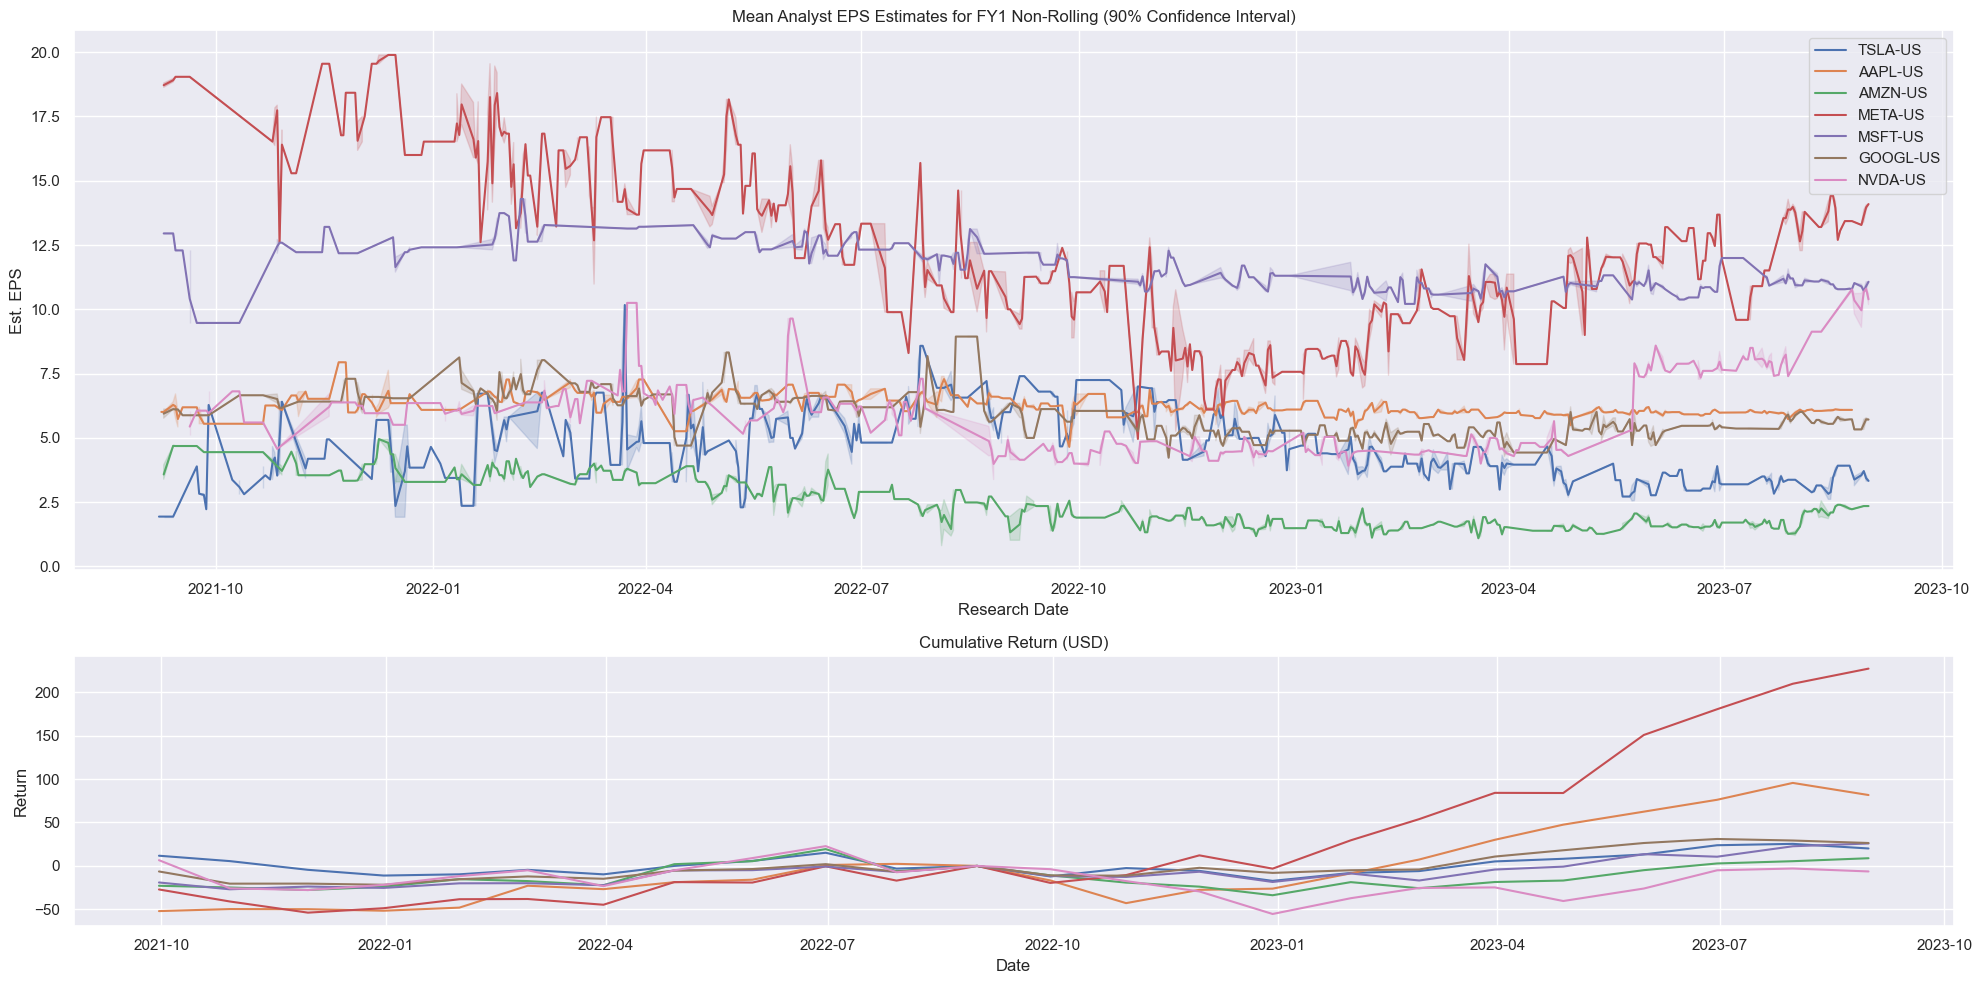

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
fig,axs = plt.subplots(2,1,figsize=(20,10),gridspec_kw={'height_ratios': [2, 1]})

sns.lineplot(df_aapl['EST_EPS_FY1'].unstack().ffill(limit = 12).stack().rename('EST_EPS_FY1').reset_index(),
                x = 'Research Date',y = 'EST_EPS_FY1',hue = 'Ticker',ax=axs[0])
axs[0].set_title('Mean Analyst EPS Estimates for FY1 Non-Rolling (90% Confidence Interval)')
axs[0].set_ylabel('Est. EPS')
axs[0].legend(loc='upper right')

sns.lineplot(df.reset_index(),
                x = 'Date',y = 'Cumulative Return',hue = 'Ticker',ax=axs[1])
axs[1].set_title('Cumulative Return (USD)')
axs[1].set_ylabel('Return')
axs[1].get_legend().remove()

plt.savefig('magnificant_7_FYE1_Broker_EPS_Estimates.png', format='png', dpi=100)

plt.tight_layout()

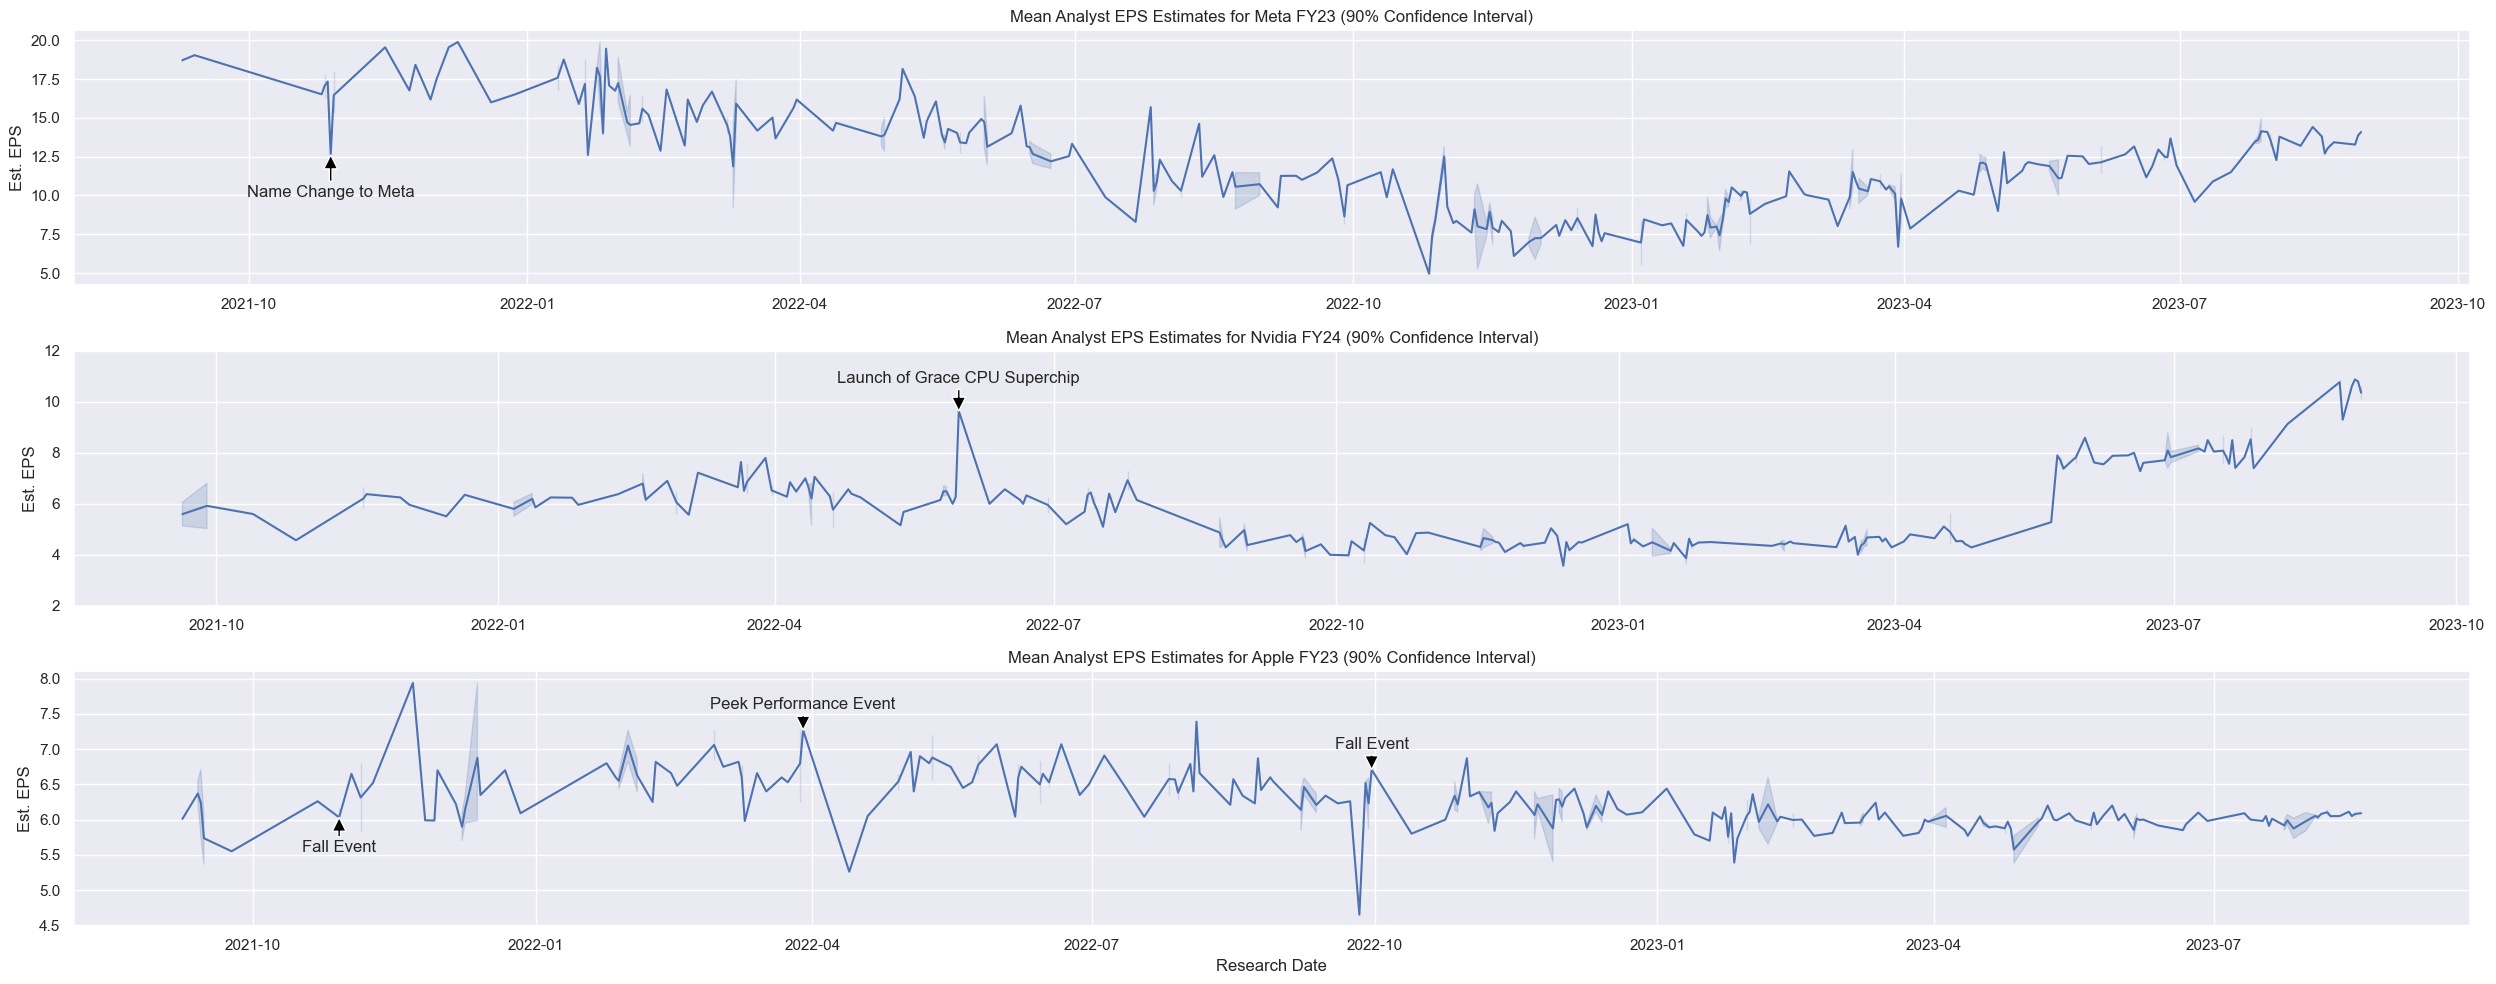

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
fig,axs = plt.subplots(3,1,figsize=(25,10))

df_mn = df_aapl.reset_index()[df_aapl.reset_index()['Ticker'].isin(['META-US'])].set_index(['Research Date','Broker Name','Ticker'])
sns.lineplot(data=df_mn['EST_EPS_FY1'].unstack().ffill(limit = 12).stack().rename('EST_EPS_FY1').reset_index(), x='Research Date', y='EST_EPS_FY1',hue='Ticker', ax=axs[0])

chosen_date1 = pd.to_datetime('2021-10-28')  # example: the latest date
chosen_y1 = df_mn.loc[chosen_date1, 'EST_EPS_FY1'].mean()  # example: the mean value on that date
axs[0].annotate('Name Change to Meta', xy=(chosen_date1, chosen_y1), xytext=(0, -30), 
                textcoords="offset points",ha='center',
                arrowprops=dict(facecolor='black', headwidth=10, width=2, headlength=10))
axs[0].set_xlabel('')
axs[0].set_title('Mean Analyst EPS Estimates for Meta FY23 (90% Confidence Interval)')
axs[0].get_legend().remove()
axs[0].set_ylabel('Est. EPS')
#sns.barplot(df_n.iloc[:,1].reset_index(),ax=axs[0],x='Date',y='NVDA-US')
df_mn = df_aapl.reset_index()[df_aapl.reset_index()['Ticker'].isin(['NVDA-US'])].set_index(['Research Date','Broker Name','Ticker'])
sns.lineplot(data=df_mn['EST_EPS_FY1'].unstack().ffill(limit = 12).stack().rename('EST_EPS_FY1').reset_index(), x='Research Date', y='EST_EPS_FY1', hue='Ticker', ax=axs[1])


chosen_date2 = pd.to_datetime('2022-05-31')  # example: the latest date
chosen_y2 = df_mn.loc[chosen_date2, 'EST_EPS_FY1'].mean()  # example: the mean value on that date
axs[1].annotate('Launch of Grace CPU Superchip', xy=(chosen_date2, chosen_y2), xytext=(0, 20), 
                textcoords="offset points",ha='center',
                arrowprops=dict(facecolor='black', headwidth=10, width=2, headlength=10))
axs[1].set_xlabel('')
axs[1].set_ylim((2,12))
axs[1].set_title('Mean Analyst EPS Estimates for Nvidia FY24 (90% Confidence Interval)')
axs[1].get_legend().remove()
axs[1].set_ylabel('Est. EPS')

df_mn = df_aapl.reset_index()[df_aapl.reset_index()['Ticker'].isin(['AAPL-US'])].set_index(['Research Date','Broker Name','Ticker'])
sns.lineplot(data=df_mn['EST_EPS_FY1'].unstack().ffill(limit = 12).stack().rename('EST_EPS_FY1').reset_index(), x='Research Date', y='EST_EPS_FY1', hue='Ticker', ax=axs[2])
chosen_date3 = pd.to_datetime('2022-09-30')  # example: the latest date
chosen_y3 = df_mn.loc[chosen_date3, 'EST_EPS_FY1'].mean()  # example: the mean value on that date
axs[2].annotate('Fall Event', xy=(chosen_date3, chosen_y3), xytext=(0, 15), 
                textcoords="offset points",ha='center',
                arrowprops=dict(facecolor='black', headwidth=10, width=2, headlength=10))

chosen_date3 = pd.to_datetime('2022-03-29')  # example: the latest date
chosen_y3 = df_mn.loc[chosen_date3, 'EST_EPS_FY1'].mean()  # example: the mean value on that date
axs[2].annotate('Peek Performance Event', xy=(chosen_date3, chosen_y3), xytext=(0, 15), 
                textcoords="offset points",ha='center',
                arrowprops=dict(facecolor='black', headwidth=10, width=2, headlength=10))
chosen_date3 = pd.to_datetime('2021-10-29')  # example: the latest date
chosen_y3 = df_mn.loc[chosen_date3, 'EST_EPS_FY1'].mean()  # example: the mean value on that date
axs[2].annotate('Fall Event', xy=(chosen_date3, chosen_y3), xytext=(0,-25), 
                textcoords="offset points",ha='center',
                arrowprops=dict(facecolor='black', headwidth=10, width=2, headlength=10))
axs[2].set_title('Mean Analyst EPS Estimates for Apple FY23 (90% Confidence Interval)')
axs[2].get_legend().remove()
axs[2].set_ylabel('Est. EPS')
# using padding
fig.tight_layout(pad=5.0)
plt.savefig('META_NVDA_AAPL_Broker_EPS.png', format='png', dpi=100)
plt.tight_layout()